In [1]:
!git clone https://github.com/Kangningthu/DeepDenoisingGuide

Cloning into 'DeepDenoisingGuide'...
remote: Enumerating objects: 869, done.
remote: Counting objects: 100% (130/130), done.
remote: Compressing objects: 100% (103/103), done.
remote: Total 869 (delta 27), reused 123 (delta 22), pack-reused 739 (from 1)
Receiving objects: 100% (869/869), 337.62 MiB | 26.36 MiB/s, done.
Resolving deltas: 100% (55/55), done.
Updating files: 100% (1167/1167), done.


In [7]:
import numpy as np
import matplotlib.pylab as plt
import matplotlib.patches as patches
import os
import torch
from skimage import io
import sys
import time
import os
import utils
from utils import *

file_root_path = '/content/DeepDenoisingGuide'
sys.path.append(file_root_path)

In [8]:
# Paths for data, pretrained models, and precomputed performance measures
pretrained_base = file_root_path + '/bias_free_denoising/pretrained/'
precomputed_base = file_root_path + '/bias_free_denoising/precomputed/'
data_base = file_root_path + '/bias_free_denoising/data/'

# Datasets available in the data folder
train_folder_path = os.path.join(data_base, 'Train400/')
test_folder_path = os.path.join(data_base, 'Test/Set68/')
set12_path = os.path.join(data_base, 'Test/Set12/')
kodak_path = os.path.join(data_base, 'Test/Kodak23/')

In [9]:
# Choose a model (pre-trained options: 'dncnn', 'unet', 'rcnn', 'sdensenet')
model = 'dncnn'

# Select the range of noise levels (stdev, relative to intensities in range [0,255])
# used during training (options are 0-10, 0-30, 0-55, 0-100).
l = 0   # lower bound of training range
h = 100 # upper bound of training range

model = load_model(os.path.join(pretrained_base, model, 'bias_free', str(l)+'-'+str(h)+'.pt'))

/content/DeepDenoisingGuide/utils/demo_utils.py:45: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint_path, map_location=lambda s, l: default_

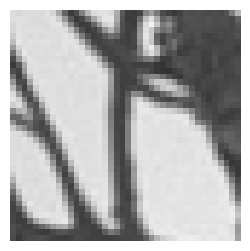

In [10]:
# choose a clean image
image_num = 15
clean_im = single_image_loader(test_folder_path, image_num)

# Crop out a 40x40 patch
clean_im = clean_im[100:140, 100:140]
dim1, dim2 = clean_im.shape

f , axs = plt.subplots(1,1 , figsize=(3,3))
axs.imshow(clean_im, 'gray', vmin=0, vmax = 1)
axs.axis('off');

In [11]:
def plot_filters_for_points(points, clean_im, dim1, dim2, patch_h=1, path_w=1, angle=5):
    """
    Plot noisy, denoised images, zoomed-in crops, and adaptive filters for two specified pixels, for each noise level.

    Args:
    points (list of tuples): List containing two tuples, each with the (x, y) coordinates of a pixel.
    clean_im (array): The clean image.
    dim1 (int): Dimension 1 of the image.
    dim2 (int): Dimension 2 of the image.
    """
    # Noise levels to examine
    noise_levels = [10, 30]
    width = 10  # Width for zooming and rectangle
    linewidth = 2  # Line width for rectangle

    for noise_level in noise_levels:
        # Add noise
        noisy_im, _ = add_noise2(clean_im.reshape(1, dim1, dim2), noise_level, 'S')

        # Denoise
        inp_test = torch.tensor(noisy_im.astype('float32'), requires_grad=True).unsqueeze(1)
        residual = model(inp_test)
        denoised = residual.squeeze(0).squeeze(0).data.numpy()

        # Create figure for this noise level
        fig, axes = plt.subplots(nrows=len(points), ncols=4, figsize=(16, 9))

        for i, point in enumerate(points):
            ix, iy = point

            # Noisy Image
            axes[i][0].imshow(noisy_im[0], 'gray', vmin=0, vmax=1)
            pa1 = patches.Rectangle((ix,iy), width=path_w, height=patch_h, angle=angle, edgecolor = [1,0,0], facecolor='red', lw=5)
            axes[i][0].add_patch(pa1)
            rect1 = patches.Rectangle((ix-width, iy-width), width*2, width*2, linewidth=linewidth, edgecolor='r', facecolor='none')
            axes[i][0].add_patch(rect1)
            axes[i][0].axis('off')

            # Denoised Image
            axes[i][1].imshow(denoised, 'gray', vmin=0, vmax=1)
            pa1 = patches.Rectangle((ix,iy), width=path_w, height=patch_h, angle=angle, edgecolor = [1,0,0], facecolor='red', lw=5)
            axes[i][1].add_patch(pa1)
            rect2 = patches.Rectangle((ix-width, iy-width), width*2, width*2, linewidth=linewidth, edgecolor='r', facecolor='none')
            axes[i][1].add_patch(rect2)
            axes[i][1].axis('off')

            # Zoomed Crop
            zoomed_crop = denoised[iy-width:iy+width, ix-width:ix+width]

            axes[i][2].imshow(zoomed_crop, 'gray', vmin=0, vmax=1)
            pa1 = patches.Rectangle((width,width), width=path_w, height=patch_h, angle=angle, edgecolor = [1,0,0], facecolor='red', lw=5)
            axes[i][2].add_patch(pa1)
            rect1 = patches.Rectangle((0,0), width*2, width*2, linewidth= linewidth*3, edgecolor='r',facecolor='none')
            axes[i][2].axis('off')

            # Gradient
            filt = torch.autograd.grad(residual[0, 0, iy, ix], inp_test, retain_graph=True)[0][0, 0].data.numpy()[iy-width:iy+width, ix-width:ix+width]
            limit = max(np.abs(np.min(filt)), np.abs(np.max(filt)))
            x = axes[i][3].imshow(filt, 'RdGy', vmin=-limit, vmax=limit)
            axes[i][3].axis('off')
            x.set_clim(-0.1, 0.1)
            plt.colorbar(x, ax=axes[i][3])

        plt.tight_layout()
        plt.show()

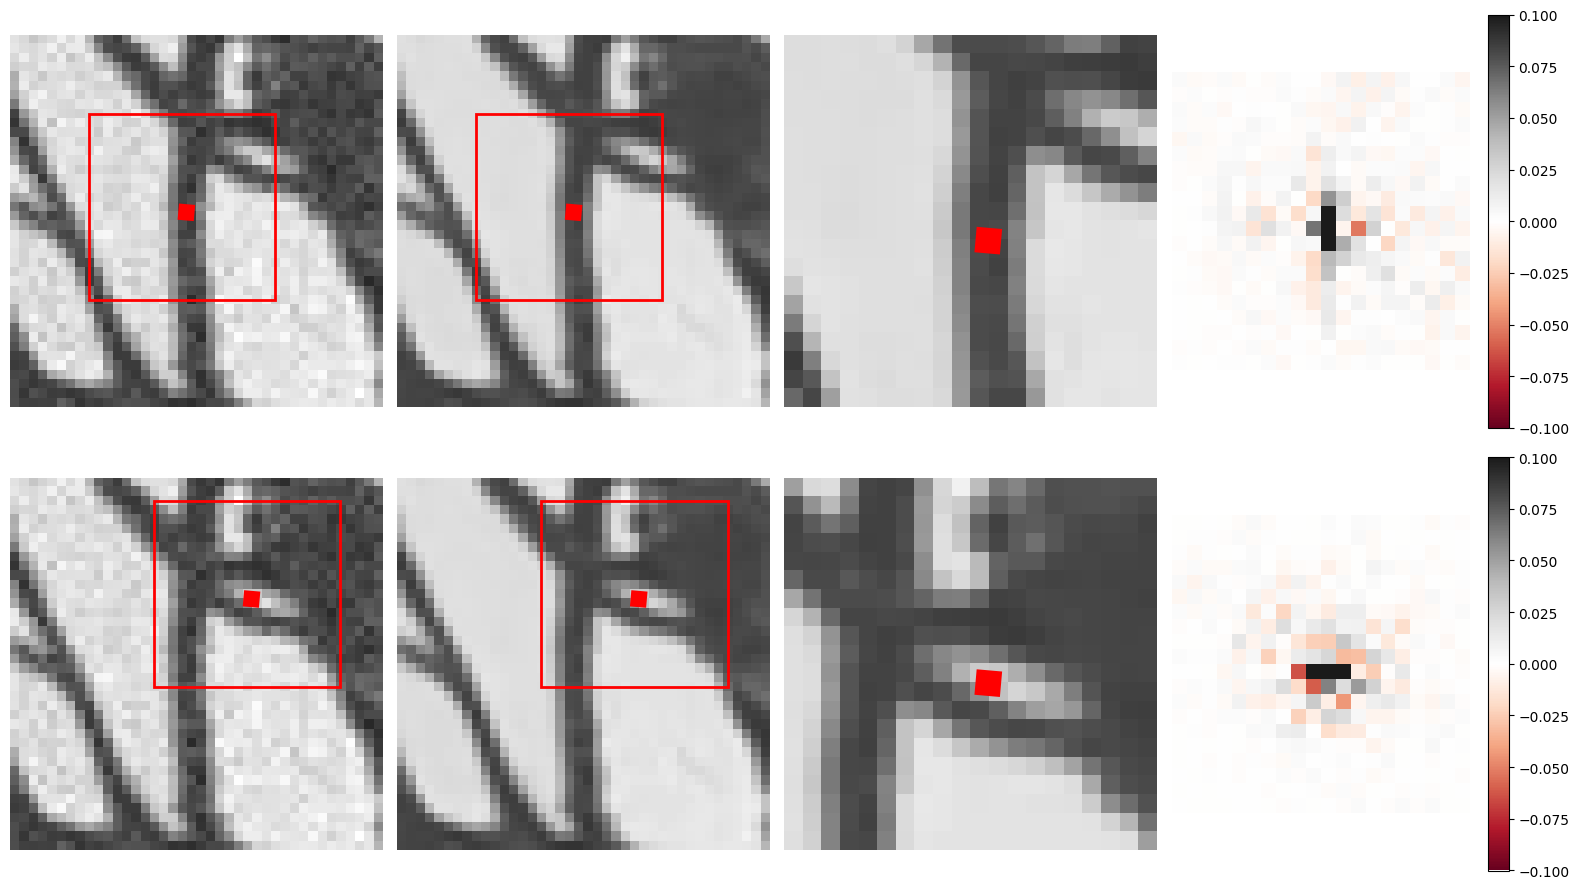

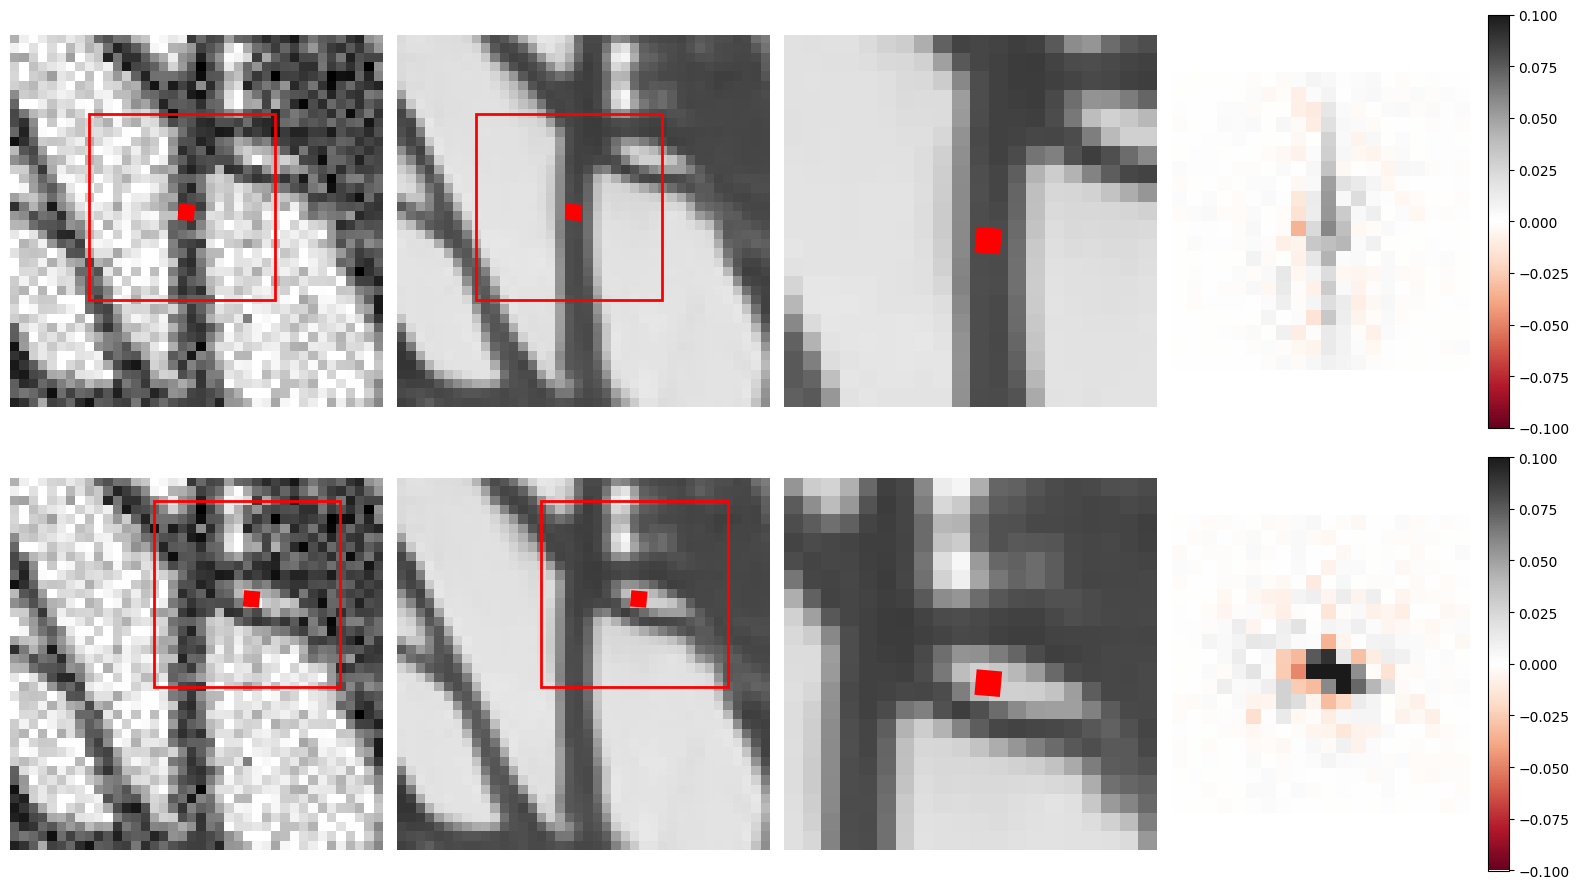

In [12]:
plot_filters_for_points([(18, 18), (25, 12)], clean_im, dim1, dim2)